# Kaschak and Glenberg

Try to replicate experiment 2 from Kaschack and Glenberg (2000) in LMs.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import torch
from collections import defaultdict
import random
import math
import pickle
import scipy

import src.sent_encoder

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
data = pd.read_csv("../data/kaschak-glenberg.csv")

In [3]:
with open("../data/bnc.pkl", "rb") as f:
  bnc_data = pickle.load(f)

## Get contextual vectors for verbs

In [4]:
LAYER = 11
enc = src.sent_encoder.SentEncoder()

In [ ]:
vecs_ditransitive = enc.sentence_vecs(data.sent_ditransitive.tolist(), verbs=data.verb.tolist())[:, LAYER]
vecs_transitive = enc.sentence_vecs(data.sent_transitive.tolist(), verbs=data.verb.tolist())[:, LAYER]

In [6]:
vecs_ditransitive.shape

(20, 768)

## Average vector for "gave"

In [7]:
gave_sentences = [s for s in bnc_data if " gave " in s]
vecs_gave = enc.sentence_vecs(gave_sentences, verbs=['gave'] * len(gave_sentences))[:, LAYER]

In [8]:
vecs_gave.shape

(700, 768)

In [9]:
vec_gave_avg = vecs_gave.mean(axis=0)

In [10]:
vec_gave_avg.shape

(768,)

## Distance to "gave" for every contextual verb vector

In [11]:
result_df = []
for ix, row in data.iterrows():
  result_df.append(pd.Series({
    'sent_ditransitive': row.sent_ditransitive,
    'sent_transitive': row.sent_transitive,
    'verb': row.verb,
    'gave_dist_ditransitive': np.linalg.norm(vec_gave_avg - vecs_ditransitive[ix]),
    'gave_dist_transitive': np.linalg.norm(vec_gave_avg - vecs_transitive[ix]),
    
    # Similar results if we use cosine instead of euclidean distance.
    #'gave_dist_ditransitive': scipy.spatial.distance.cosine(vec_gave_avg, vecs_ditransitive[ix]),
    #'gave_dist_transitive': scipy.spatial.distance.cosine(vec_gave_avg, vecs_transitive[ix]),
  }))

result_df = pd.DataFrame(result_df)

## Test significance

Result: ditransitive is slightly closer to "gave" than transitive, but difference is not significant.

In [13]:
gave_delta = result_df.gave_dist_transitive - result_df.gave_dist_ditransitive
print("Average gave_dist_transitive - gave_dist_ditransitive:", np.mean(gave_delta))
print("Number of sentences where ditransitive closer to vec(gave):", np.sum(gave_delta > 0))
print("Number of sentences where transitive closer to vec(gave):", np.sum(gave_delta < 0))

Average gave_dist_transitive - gave_dist_ditransitive: 0.07953939437866211
Number of sentences where ditransitive closer to vec(gave): 10
Number of sentences where transitive closer to vec(gave): 10


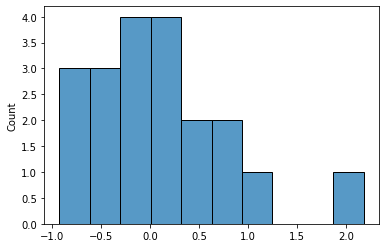

In [14]:
sns.histplot(gave_delta, bins=10)
plt.show()

In [15]:
scipy.stats.ttest_rel(result_df.gave_dist_transitive, result_df.gave_dist_ditransitive)

Ttest_relResult(statistic=0.49259415490059427, pvalue=0.6279434903446379)